In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAexGothic')
import japanize_matplotlib
import glob
import pickle

In [41]:
#最大表示列数の指定（ここでは75列を指定）
pd.set_option('display.max_columns', 75)

In [30]:
#企業コードを書いたexcelファイルを読み込む
companies_df = pd.read_excel('code.xlsx', index_col=0, header=0)
#企業コードをリスト化
code_list = companies_df.index.to_list()
companies_df

,企業名,平均給料(就職四季報),非総合職
銘柄コード,,,
3402,東レ,975,NaN
3405,クラレ,1048,NaN
3407,旭化成,904,NaN
4004,レゾナック,959,NaN
4005,住友化学,982,NaN
4021,日産化学,1010,NaN
4042,東ソー,925,NaN
4063,信越化学工業,886,1.0
4088,エアウォーター,877,NaN


In [31]:
# 読み込むファイル名を指定
filename = 'df_dict.pkl'

# バイナリモードでファイルを開き、オブジェクトを読み込む
with open(filename, 'rb') as file:
    df_dict = pickle.load(file)

In [32]:
#PERトレンドグラフ(5年分)を作成
years = [2019, 2020, 2021, 2022, 2023]

# code_list 内の各企業コードに対して処理を実行
for target in code_list:
    # companies_df に企業コードが存在しなければスキップ
    if str(target) not in df_dict.keys():
        continue
    
    # グラフの作成開始
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # companies_df から企業名を取得（インデックスが整数であることを前提）
    company_name = companies_df.loc[int(target), '企業名']

    # 第1の y 軸を設定：売上総利益率のプロット
    color1 = 'tab:blue'
    ax1.set_xlabel('年度', fontsize=14)
    ax1.set_ylabel('売上総利益率（粗利率）[%]', color=color1, fontsize=14)
    ax1.plot(df_dict[str(target)]['決算年度'][:-1],
             df_dict[str(target)]['売上総利益率'][:-1],
             color=color1, marker='o', label='売上総利益率')
    ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)

    # x 軸の目盛りを指定の年に設定
    ax1.set_xticks(years)
    ax1.set_xticklabels([str(year) for year in years], fontsize=12)

    # 第2の y 軸を設定：PER（会予）のプロット
    ax2 = ax1.twinx()  # 共有 x 軸の第2 y 軸を作成
    color2 = 'tab:red'
    ax2.set_ylabel('PER（会予）', color=color2, fontsize=14)
    ax2.plot(df_dict[str(target)]['決算年度'][:-1],
             df_dict[str(target)]['PER（会予）'][:-1],
             color=color2, marker='s', label='PER（会予）')
    ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)

    # グラフタイトルを設定
    plt.title(f'{str(target)} {company_name}', fontsize=16)
    plt.grid(False)
    fig.tight_layout()

    # グラフをPNGファイルとして保存
    plt.savefig(f'./graph/trend/5year_trend_{str(target)}.png', dpi=150, facecolor='white')
    plt.close()  # 次のループのために現在の図を閉じる

In [33]:
index_to_label = {
    0: 'result_df_2023',
    1: 'result_df_2022',
    2: 'result_df_2021',
    3: 'result_df_2020',
    4: 'result_df_2019',
    5: 'result_df_5mean'
}

In [34]:
# 各結果データフレームを格納するための辞書
results = {}

# 各インデックスに対する処理を行う
for idx, df_name in index_to_label.items():
    records = []

    for code in code_list:
        # companies_df に企業コードが存在しなければスキップ
        if str(code) not in df_dict.keys():
            continue
        # 現在の企業コードに対応するデータフレームの idx 行目を取得
        row = df_dict[str(code)].iloc[idx]

        # 必要な値を抽出
        gross_profit_rate = row['売上総利益率']
        per_value = row['PER（会予）']

        # 辞書形式で記録を保存
        records.append({
            'code': code,
            '売上総利益率': gross_profit_rate,
            'PER（会予）': per_value
        })

    # リストからデータフレームを作成し、'code' をインデックスに設定
    df_temp = pd.DataFrame(records).set_index('code')

    # インデックスを企業名に変換
    df_temp.index = df_temp.index.map(companies_df['企業名'])

    # 'PER（会予）' 列を数値型に変換
    df_temp['PER（会予）'] = pd.to_numeric(df_temp['PER（会予）'], errors='coerce')

    # 作成したデータフレームを辞書に保存
    results[df_name] = df_temp

In [35]:
for df in results.values():   
    # NaN を含む行をすべて削除
    df.dropna(inplace=True)
    
    # 'PER（会予）' が 70 以上の行を削除
    if 'PER（会予）' in df.columns:
        condition = df['PER（会予）'] >= 70
        df.drop(df[condition].index, inplace=True)

In [36]:
# results 辞書内の各データフレームについて処理
for key, df in results.items():
    # 新しい図を作成
    plt.figure(figsize=(10, 8))

    # 散布図を作成：x軸に 'PER（会予）', y軸に '売上総利益率'
    plt.scatter(df['PER（会予）'], df['売上総利益率'], s=100)

    # 各点に企業名を注釈として追加
    for company, row in df.iterrows():
        # 数値が NaN でないことを確認してから注釈を追加
        if pd.notna(row['PER（会予）']) and pd.notna(row['売上総利益率']):
            plt.annotate(company, 
                         (row['PER（会予）'], row['売上総利益率']),
                         textcoords="offset points",  
                         xytext=(5,5),               
                         ha='left',                  
                         fontsize=14)

    # 軸ラベルを設定
    plt.xlabel('PER（会予）', fontsize=16)
    plt.ylabel('売上総利益率（粗利率）[%]', fontsize=16)

    # メモリラベルのフォントサイズを設定
    plt.tick_params(axis='both', which='major', labelsize=14)

    # グリッドを表示
    plt.grid(True)

    # 余白を自動調整
    plt.tight_layout()

    # キーに基づいて注釈テキストを設定（例：result_df_2023 → "2023年度のデータです"）
    # キーから年度情報を抽出
    if '5mean' in key:
        note = '注: データは5年平均です'
    else:
        # 例: 'result_df_2023' から '2023年度のデータです' を生成
        year = key.replace('result_df_', '')
        note = f'注: {year}年度のデータです'

    # グラフ下部に注釈を追加
    plt.figtext(0.8, 0.01, note, wrap=True, 
                horizontalalignment='center', fontsize=12, color='gray')

    # ファイル名をキーに基づいて決定し、PNG ファイルとして保存
    filename = f'./graph/PER/arari_PER_{key}.png'
    plt.savefig(filename, dpi=150, facecolor='white')
    plt.close()  # 次の図のために現在の図を閉じる

In [48]:
# 表示したい年度（例として5年間）
years = [2019, 2020, 2021, 2022, 2023]

# code_list 内の各企業コードに対して処理を実行
for target in code_list:
    # companies_df に企業コードが存在しなければスキップ
    if str(target) not in df_dict.keys():
        continue

    # グラフ作成のための図と軸を生成
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 企業名の取得（companies_df のインデックスが整数である前提）
    company_name = companies_df.loc[int(target), '企業名']

    # 企業の各指標のデータを取得（末尾の1行が不要な場合はスライスで除外）
    # ※ここでは決算年度のリストを使ってx軸を設定します。
    fiscal_years = list(reversed(df_dict[str(target)]['決算年度'][:-1]))
    revenue = list(reversed(df_dict[str(target)]['売上高'][:-1]))
    gross_profit = list(reversed(df_dict[str(target)]['売上総利益'][:-1]))
    gross_profit_margin = list(reversed(df_dict[str(target)]['売上総利益率'][:-1]))

    # x軸の位置を生成（棒グラフを横並びに表示するための位置調整）
    x = np.arange(len(fiscal_years))
    bar_width = 0.35

    # --- ax1: 売上高と売上総利益の棒グラフ ---
    color1 = 'tab:blue'
    ax1.set_xlabel('年度', fontsize=14)
    ax1.set_ylabel('金額', color=color1, fontsize=14)

    # 売上高の棒グラフ（x位置を左にずらす）
    bars1 = ax1.bar(x - bar_width/2, revenue, width=bar_width, color='skyblue', label='売上高')
    # 売上総利益の棒グラフ（x位置を右にずらす）
    bars2 = ax1.bar(x + bar_width/2, gross_profit, width=bar_width, color='dodgerblue', label='売上総利益')

    ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)
    ax1.set_xticks(x)
    # x軸のラベルは fiscal_years を利用（もしくはyearsリストに合わせる場合は調整してください）
    ax1.set_xticklabels(fiscal_years, fontsize=12)

    # --- ax2: 売上総利益率の折れ線グラフ ---
    ax2 = ax1.twinx()  # ax1とx軸を共有する第2のy軸を作成
    color2 = 'tab:red'
    ax2.set_ylabel('売上総利益率（%）', color=color2, fontsize=14)
    line, = ax2.plot(x, gross_profit_margin, color=color2, marker='o', linestyle='-', linewidth=2, label='売上総利益率')
    ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # グラフタイトルの設定
    plt.title(f'{str(target)} {company_name}', fontsize=16)
    plt.grid(False)
    fig.tight_layout()

    # グラフをPNGファイルとして保存
    plt.savefig(f'./graph/trend/5year_barplot_{str(target)}.png', dpi=150, facecolor='white')
    plt.close()  # 次のループのために現在の図を閉じる

In [50]:
# 抽出結果を保持するリストを用意
records = []

for code in code_list:
    # companies_df に企業コードが存在しなければスキップ
    if str(code) not in df_dict.keys():
        continue

    # 各企業コードに対応するデータフレームの先頭行を取得
    first_row = df_dict[str(code)].iloc[0]

    # 各企業コードに対応するデータフレームの最終行を取得
    last_row = df_dict[str(code)].iloc[-1]
    
    # 最終行から必要な値を抽出
    gross_profit_rate = last_row['売上総利益率']
    per_value = last_row['売上増加率']
    
    # 辞書形式で記録を保存
    records.append({
        'code': code,
        '売上総利益率': gross_profit_rate,
        '売上増加率': per_value
    })

# リストからデータフレームを作成し、'code' をインデックスに設定
grow_df = pd.DataFrame(records).set_index('code')
# Series を直接用いてインデックスを変換する方法 
grow_df.index = grow_df.index.map(companies_df['企業名'])
grow_df

,売上総利益率,売上増加率
code,,
東レ,19.00,4.773896
クラレ,31.40,8.421033
旭化成,30.54,6.916215
レゾナック,21.44,10.965889
住友化学,29.18,3.219284
日産化学,44.88,2.404971
東ソー,25.24,7.231282
信越化学工業,39.00,14.234972
エアウォーター,21.70,6.225302


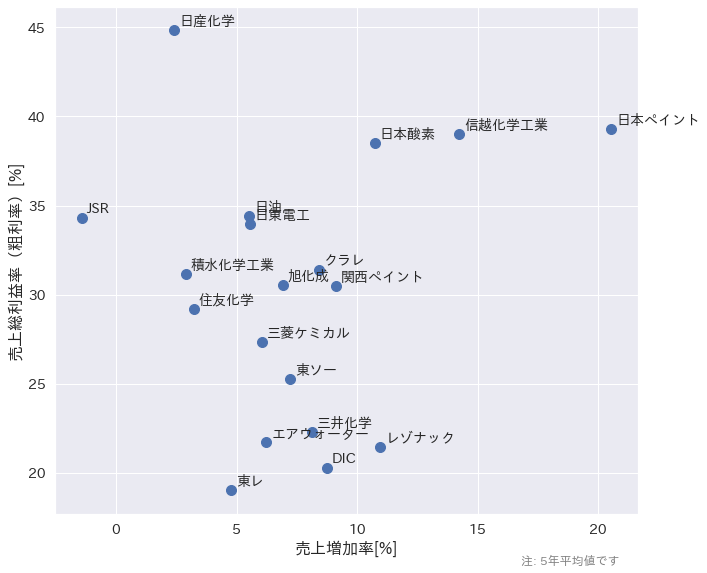

In [53]:
# グラフのサイズを設定（任意）
plt.figure(figsize=(10, 8))

# 散布図を作成：x軸に 'PER（会予）', y軸に '売上総利益率'
plt.scatter(grow_df['売上増加率'], grow_df['売上総利益率'], s=100)

# 各点に企業名を注釈として付ける
for company, row in grow_df.iterrows():
    plt.annotate(company, 
                 (row['売上増加率'], row['売上総利益率']),
                 textcoords="offset points",  # テキスト表示位置の指定
                 xytext=(5,5),               # プロットからのオフセット
                 ha='left',                  # 水平方向の配置
                 fontsize=14)                 # フォントサイズ（必要に応じて調整）

# 軸ラベルを設定
plt.xlabel('売上増加率[%]', fontsize=16)
plt.ylabel('売上総利益率（粗利率）[%]', fontsize=16)

# メモリラベルのフォントサイズを大きくする
plt.tick_params(axis='both', which='major', labelsize=14)

# タイトルを設定（任意）
#plt.title('企業ごとのPER（会予）と売上総利益率の散布図')

# 5年平均のデータであることをグラフ下部に記載
plt.figtext(0.8, 0.01, '注: 5年平均値です', wrap=True, 
            horizontalalignment='center', fontsize=12, color='gray')

# グリッドを表示（任意）
plt.grid(True)
plt.tight_layout()

# グラフを表示
#plt.savefig('arari_grow_5mean.png', dpi=150, facecolor='white')